# Customer segmentation project

## Intro
The current notebbok presents a segmentation problem. The objective of segmentation is to segment customers into different clusters based on certain attributes.
This exercise is quite common in Marketing when launching promotions in order to target similar customers with specific ads, promotions.

The dataset used was download from Kaggle [https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

My aim is not just to segment customers into different clusters /
segments (this is where usually most tutorials stop) but also to explain how clusters are determined.

---



## Install packages

In [ ]:
# install dtreeviz package require to plot decision trees
%pip install dtreeviz

In [ ]:
# Install Gitly to render Plotly graphs on Github
%pip install gitly

## Import relevant libraries and  packages

In [5]:
#from pyforest import *
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.plotting import scatter_matrix
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree
import pydot
from sklearn.cluster import KMeans
import dtreeviz
from dtreeviz.trees import *
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.utils import resample
from collections import Counter
import plotly        
import plotly.io as pio
import plotly.express as px
from gitly.colab.plot import GitlyPlotter # Only imported to view Plotly graphs on Github
import pydotplus
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format
random.seed(10)

## I- A brief look at our dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Customer segmentation/Mall_Customers.csv")

In [8]:
# Visualize first rows of our dataset
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
print(f'Our dataset has {df.shape[0]} samples and {df.shape[1]} features')

Our dataset has 200 samples and 5 features


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


We can see from the above information than no samples contain missing values

In [11]:
# Print descriptive statistics of numerical variables
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


In [12]:
# Print descriptive statistics of categorical variables
df.describe(include='object')

,Gender
count,200
unique,2
top,Female
freq,112


## II- Data visualization

### a) Univariate analysis

***Gender***

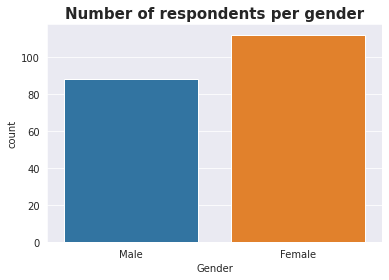

In [13]:
sns.countplot(x='Gender', data=df)
plt.title("Number of respondents per gender",fontname="DejaVu Sans", size=15,fontweight="bold")
plt.show();

There are more femal respondents (+20%) than male respondents

***Age***

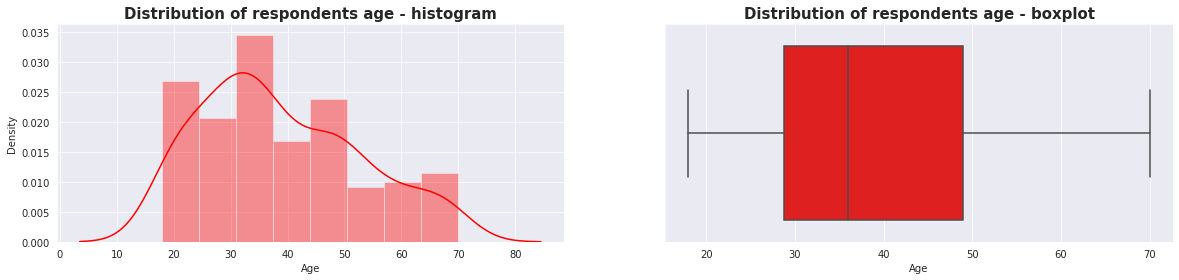

In [14]:
# Plot histograms
f, ax = plt.subplots(1, 2, figsize=(20,4))
sns.distplot(df['Age'], color="red", ax=ax[0])
ax[0].set_title("Distribution of respondents age - histogram",fontname="DejaVu Sans", size=15,fontweight="bold")
sns.boxplot(df['Age'], color="red", ax=ax[1])
ax[1].set_title("Distribution of respondents age - boxplot",fontname="DejaVu Sans", size=15,fontweight="bold")
plt.show();

The age distribution is slighted skewed towards the left handside (ie younder repondents).
The boxplot reveals that the average age of respondents is located around 35 y.o

***Income***

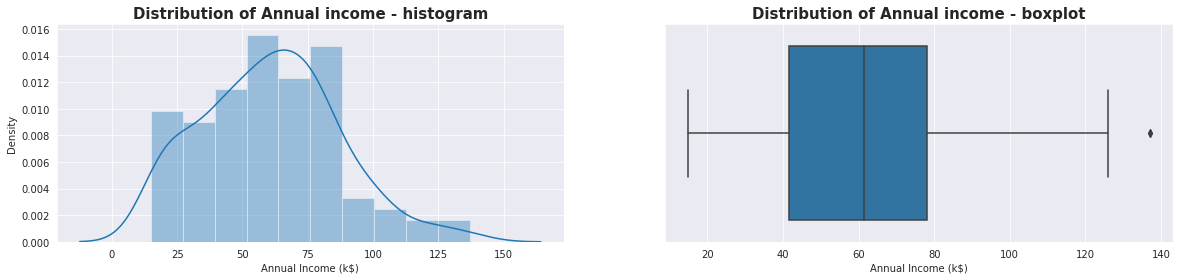

In [15]:
# # Plot histogram and boxplot of Annual income
f, ax = plt.subplots(1,2, figsize=(20,4))
sns.distplot(df['Annual Income (k$)'], ax=ax[0])
ax[0].set_title("Distribution of Annual income - histogram", fontname="DejaVu Sans", size=15,fontweight="bold")
sns.boxplot(df['Annual Income (k$)'], ax=ax[1])
ax[1].set_title("Distribution of Annual income - boxplot", fontname="DejaVu Sans", size=15,fontweight="bold")
plt.show();

The age distribution is slightly skewed towards the left handside (ie lower incomes)

The above boxplot inform us that the median income of respondents is located around 60K$. There is only one utlier but taking into consideration that our sample size is quite small (200) it is not surprising

***Spending Score***

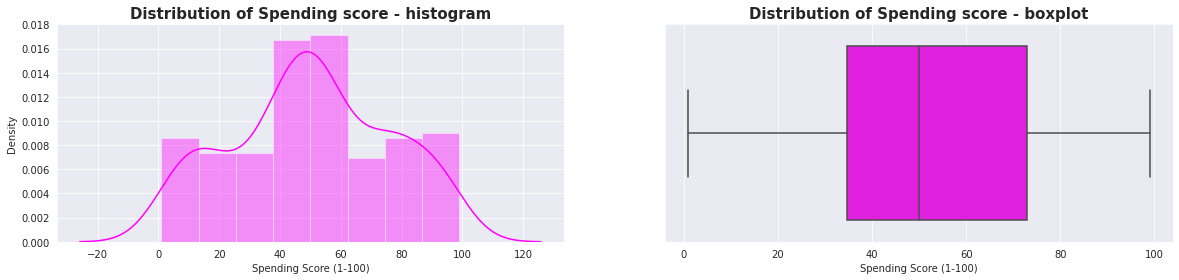

In [16]:
f, ax = plt.subplots(1,2, figsize=(20,4))
sns.distplot(df['Spending Score (1-100)'], color='magenta', ax=ax[0])
ax[0].set_title("Distribution of Spending score - histogram", fontname="DejaVu Sans", size=15,fontweight="bold")
sns.boxplot(df['Spending Score (1-100)'], color='magenta', ax=ax[1])
ax[1].set_title("Distribution of Spending score - boxplot",  fontname="DejaVu Sans", size=15,fontweight="bold")
plt.show();

The median spend score is around 50

### b) Multivariate analysis

We will first plot a pairplot that shows how variables correlate

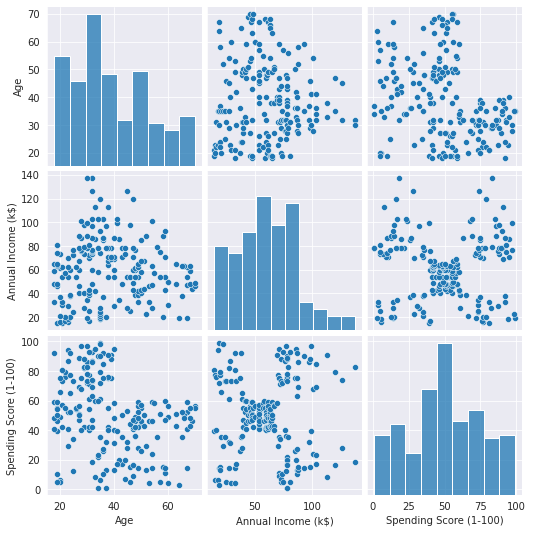

In [17]:
sns.pairplot(df[['Age','Annual Income (k$)', 'Spending Score (1-100)']])
plt.show()

When looking at the grapgs above, we can see a net segmentation of respondents  by Annual Income and Spending score

***Income vs Gender***

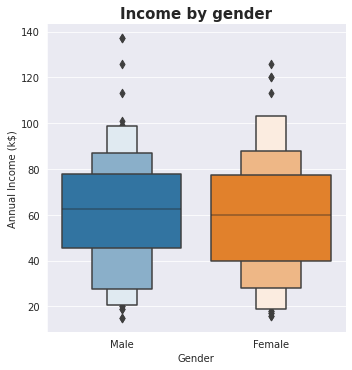

In [18]:
sns.catplot(x='Gender', y='Annual Income (k$)', kind='boxen', data=df)
plt.title("Income by gender", fontname="DejaVu Sans", size=15, fontweight="bold")
plt.show();

The median income for men in our sample is slightly higher than that of women. We notice a few outliers for men and women

We will now print the exact value of annual income per Gender and per quartile in order to interpret better the boxplot above

In [19]:
array_income_male = df[df['Gender']=='Male']['Annual Income (k$)']
array_income_female = df[df['Gender']=='Female']['Annual Income (k$)']
array_income_male = np.array(array_income_male)
array_income_female = np.array(array_income_female)

In [20]:
print("Q2 quantile of incomes of female respondent (50th percentile) : ", np.quantile(array_income_female, .50))
print("Q1 quantile of incomes of female respondent (25th percentile)  : ", np.quantile(array_income_female, .25))
print("Q3 quantile of incomes of female respondent (75th percentile)  : ", np.quantile(array_income_female, .75))

Q2 quantile of incomes of female respondent (50th percentile) :  60.0
Q1 quantile of incomes of female respondent (25th percentile)  :  39.75
Q3 quantile of incomes of female respondent (75th percentile)  :  77.25


In [21]:
print("Q2 quantile of incomes of male respondent (50th percentile) : ", np.quantile(array_income_male, .50))
print("Q1 quantile of incomes of male respondent (25th percentile)  : ", np.quantile(array_income_male, .25))
print("Q3 quantile of incomes of male respondent (75th percentile)  : ", np.quantile(array_income_male, .75))

Q2 quantile of incomes of male respondent (50th percentile) :  62.5
Q1 quantile of incomes of male respondent (25th percentile)  :  45.5
Q3 quantile of incomes of male respondent (75th percentile)  :  78.0


Men tend to earn slightly more than women:
- 50% men earn between 45.5k - 62.5k USD (versus 39.75k - 60k USD for women)

***Income vs spending score***

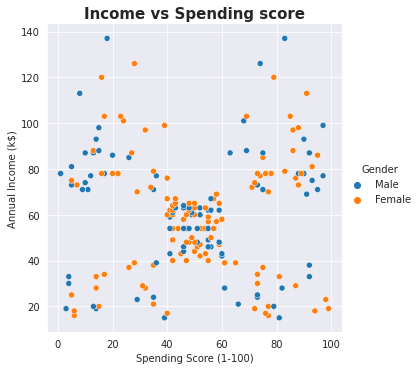

In [22]:
sns.relplot(x='Spending Score (1-100)', y='Annual Income (k$)', hue='Gender', data=df)
plt.title("Income vs Spending score", fontname="DejaVu Sans", size=15, fontweight="bold")
plt.show();

***Spending score vs Gender***

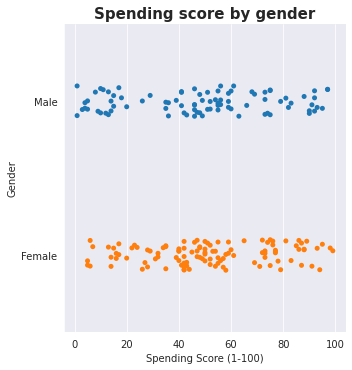

In [23]:
sns.catplot(x='Spending Score (1-100)', y='Gender', data=df)
plt.title("Spending score by gender", fontname="DejaVu Sans", size=15, fontweight="bold")
plt.show();

In general, most respondents are situated in the 40-60 bracket

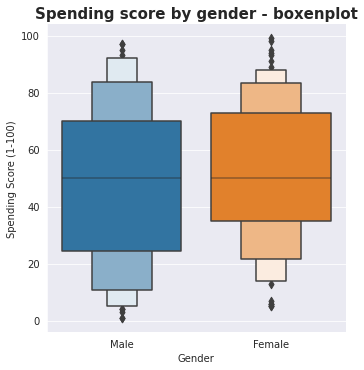

In [24]:
sns.catplot(x="Gender", y="Spending Score (1-100)", kind="boxen", data=df)
plt.title("Spending score by gender - boxenplot", fontname="DejaVu Sans", size=15, fontweight="bold")
plt.show();

The boxenplot above confirms that women tend to have a highter spending score than men, eventhough the median spending score is similar for both genders

## III- Modelling

In this part of the project, we will create a model to segment our customers into clusters

### a) Data preprocessing

***Categorical variables***

Before modelling, we need to transform our only categorical feature **Gender**

In [25]:
# Replace Male and Female by 0 or 1
df['Gender'] = df['Gender'].map({'Female':0,'Male':1}).astype(np.int)

In [26]:
# Drop customerID
data = df.drop("CustomerID", axis=1)

In [27]:
# Show the columns of our dataset
data.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

### b) Modelling

We will model without specifying the number of clusters and see the outcome. When fitting a clustering model, we can specify the number of cluster. This time we will not do it and let the algorithm do the finding.

In [28]:
# Instantiate and fit a model
kmeans = KMeans()
kmeans.fit(data)
y_pred = kmeans.predict(data)

In [29]:
# A quick look at predicted clusters
y_pred

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 0, 2, 0, 5,
       4, 2, 0, 5, 5, 5, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 5,
       0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 5, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5,
       5, 0, 0, 5, 0, 5, 5, 5, 0, 5, 0, 5, 5, 0, 0, 5, 0, 5, 0, 0, 0, 0,
       0, 5, 5, 5, 5, 5, 0, 0, 0, 0, 5, 5, 5, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       5, 1, 3, 1, 3, 1, 3, 1, 3, 1, 5, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7, 6, 7,
       6, 7], dtype=int32)

In [30]:
print(f'Number of clusters: {len(kmeans.cluster_centers_)}')

Number of clusters: 8


In [31]:
# Include predicted cluster in our dataset
data['Cluster']= y_pred

In [32]:
# Visualize first rows of our dataset
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,4
1,1,21,15,81,2
2,0,20,16,6,4
3,0,23,16,77,2
4,0,31,17,40,4


Now, let us visualize our clusters against the clusters we discovered while plotting income vs spending score

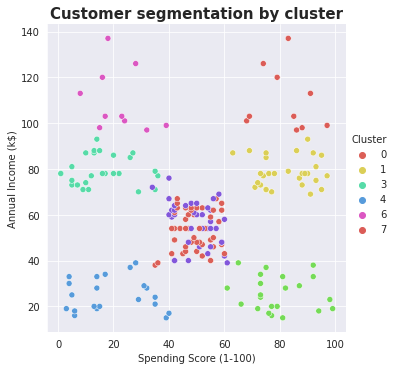

In [33]:
sns.relplot(x='Spending Score (1-100)', y='Annual Income (k$)', hue='Cluster', palette="hls", data=data)
plt.title("Customer segmentation by cluster", fontname="DejaVu Sans", size=15, fontweight="bold")
plt.show();
plt.show();

We see that our algorithm did not find the same exact clusters we got earlier when plotting **Annual Income** versus **Spending Score**

We can clearly distinguish a unique cluster in the middle of our graph. However, our model struggled to identify this cluster and included in this cluster observations belonging to 2 other clusters.

Now, let us set the number of clusters. Earlier after a performing a bivariate analysis, we noticed 5 clusters correlated to Spending Score and Annual Income. Therefore, we know we should have 5 clusters. We will model using 5 clusters.

In [34]:
# Instantiate and fit model with updated number of cluster
kmeansbis = KMeans(n_clusters= 5)
kmeansbis.fit(data.iloc[:,:-1])
y_pred2 = kmeansbis.predict(data.iloc[:,:-1])

In [35]:
#Now we will make predicts in order to establish new clusters
y_pred2 = kmeansbis.predict(data.iloc[:,:-1])

In [36]:
# Include predicted cluster in our dataset
data['Cluster2']= y_pred2

In [37]:
# Quick look at our dataset to make sure the new clusters have been added
data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Cluster2
0,1,19,15,39,4,2
1,1,21,15,81,2,0
2,0,20,16,6,4,2
3,0,23,16,77,2,0
4,0,31,17,40,4,2


In [38]:
# A quick look at predicted clusters
y_pred2

array([2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 4, 1, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       3, 4], dtype=int32)

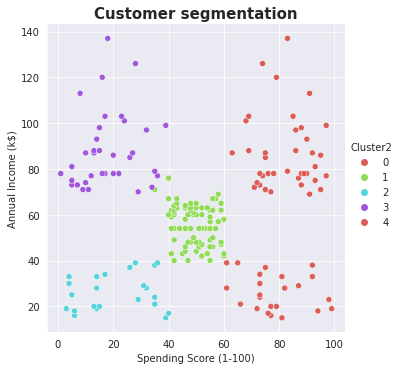

In [39]:
sns.relplot(x='Spending Score (1-100)', y='Annual Income (k$)', hue='Cluster2', palette="hls", data=data)
plt.title("Customer segmentation", fontname="DejaVu Sans", size=15,fontweight="bold")
plt.show();

Clusters are better organized than in our previous model. Now we see only 1 cluster in the middle of our graph

In [40]:
# Instatiate gitly as a object of GitlyPlotter: Parameters for the constructor could be git, github or colab
gitly = GitlyPlotter('github')

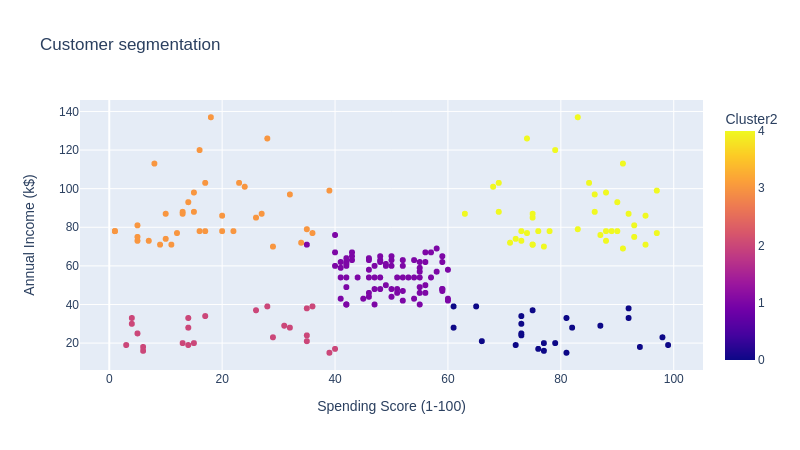

In [41]:
# Plot a scatter plot of our cluster using Plotly which renders a nicer plot than Seaborn
fig = px.scatter(data, x='Spending Score (1-100)', y='Annual Income (k$)', color='Cluster2', title="Customer segmentation")
gitly.show(fig) # to run only to view Plotly graph on Github otherwise replace by fig.show()
#fig.show()

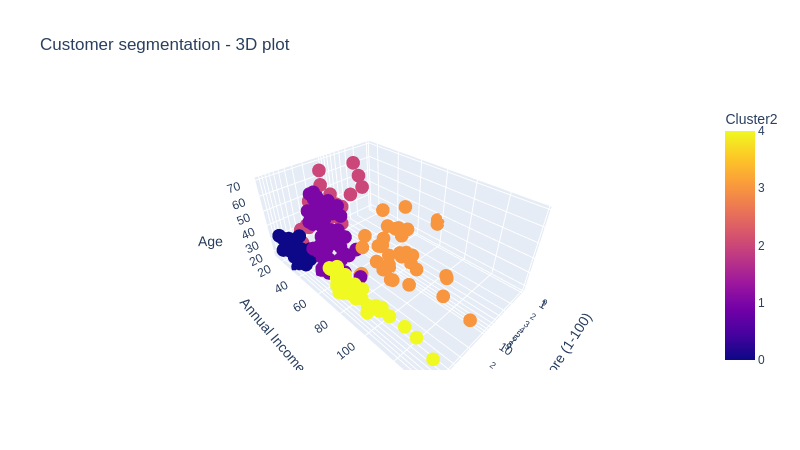

In [42]:
# Plot a 3D scatter plot with Plotly
fig = px.scatter_3d(data, 
                    x='Spending Score (1-100)', 
                    y='Annual Income (k$)',
                    z='Age', color='Cluster2',
                    log_x=True,
                    title="Customer segmentation - 3D plot",
                    #template='presentation',
                    height=700,

)
gitly.show(fig) # to run only to view Plotly graph on Github otherwise replace by fig.show()
#fig.show()

Here, we have managed to segment perfectly our samples with 5 clusters

In [43]:
#Number of observations per cluster
print("Number of observations per cluster:")
data['Cluster2'].value_counts()

Number of observations per cluster:


1    79
4    39
3    36
2    23
0    23
Name: Cluster2, dtype: int64

In [44]:
# Drop "Cluster" variables as it contains inadequate number of cluster (7)
data.drop('Cluster', axis=1, inplace=True)

In [45]:
# Quick sanity check to make sure vzariable was dropped
data.head(5)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster2
0,1,19,15,39,2
1,1,21,15,81,0
2,0,20,16,6,2
3,0,23,16,77,0
4,0,31,17,40,2


### c) Improving our model

I will now try to improve our model using the elbow method to figure out the optimal number of clusters

In [46]:
K = range(1,12)
wss = []

for k in K:
    kmeans = KMeans(n_clusters= k)
    kmeans.fit(data.iloc[:,:-1])
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [47]:
#Calculate the Within-Cluster-Sum of Squared Errors (WSS) for different values of k, 
#and choose the k for which WSS after which the WSS drop slows down
mycenters = pd.DataFrame({'Cluster': K, 'WSS': wss})
mycenters

,Cluster,WSS
0,1,"308,862.06"
1,2,"212,889.44"
2,3,"143,391.59"
3,4,"104,414.68"
4,5,"75,399.62"
5,6,"58,350.65"
6,7,"51,201.74"
7,8,"44,684.93"
8,9,"40,621.19"
9,10,"37,509.98"


***Elbow plot***

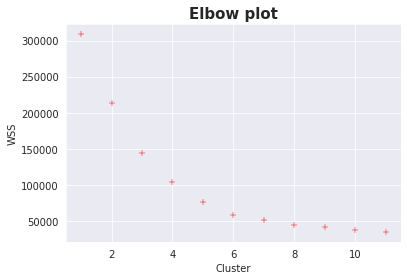

In [48]:
sns.scatterplot(x='Cluster', y="WSS", data=mycenters, marker='+', color='red')
plt.title("Elbow plot", size=15, fontweight='bold')
plt.show()

Reading this graph is not that intuive. It seems the elbow is located around 5

***Visualizing Elbow with Yellowbrick***

The Yellowbrick package offer a number of visualizations that helps assess model performance.
There are tools to assess clustering models and assess the optimal number of clusters such the elbow plot (more easily interpreted than standard elbow plot).

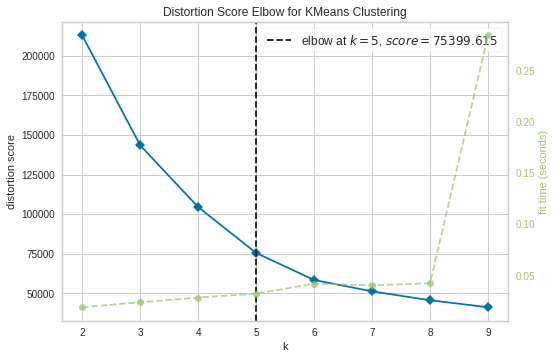

In [49]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(kmeansbis, k=(2,10))
visualizer.fit(data.iloc[:,:-1])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The above graph confirms that the ideal number of cluster is 5

***Visualizing Silhouette with Yellowbrick***

Silhouette plots are used to assess the homogeneity of clusters. We will create a Silhouette plot to assess our clusters

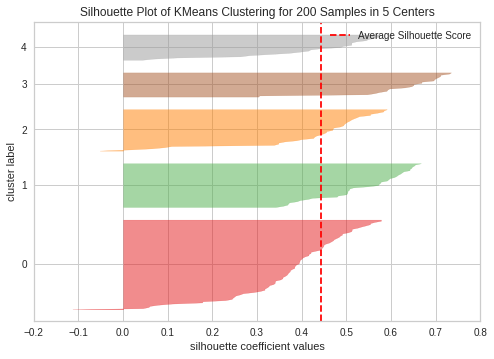

In [50]:
from yellowbrick.cluster import SilhouetteVisualizer
# Plot Silhouette plot
model = SilhouetteVisualizer(KMeans(5))
model.fit(data.iloc[:,:-1])
model.show()

From the above plot, we can conclude that some clusters are more homogeous than others.  We can conclude saying that our clusters are qualitative as most observations are not that far off from the average Silhouette score line (in red).

Cluster 1 contains observations that are more heterogeneous than the other clusters (more observations on the left side of the Average Silhouette score).

In a real business setting, Marketing might decide to split Cluster 1 in 2 clusters in order to get a more homogeneous cluster.

***Visualizing cluster distance with Yellowbrick***

Yellowbrick offers an InterclusterDistance plot to assess how different clusters are from each other in terms of characteristics.

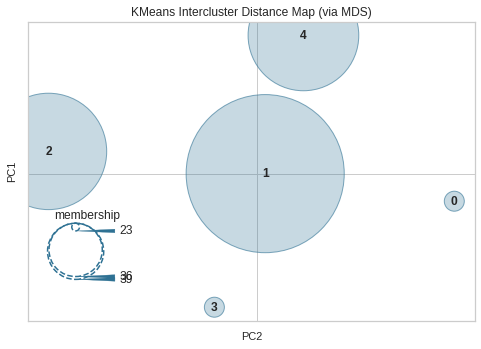

In [51]:
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering model and visualizer
model = KMeans(5)
visualizer = InterclusterDistance(model)

# Fit the data to the visualizer
visualizer.fit(data.iloc[:,:-1])       
visualizer.show()   

We notice that cluster 2 (one of the smaller clusters with cluster 4) is very far off other cluster in terms of characteristics

## IV- Interpreting clustering results

In a normal professional setting, the job does not stop here. It is a great thing to segment customers into different clusters. However, our Marketing stakeholders will want to know how clusters were formed, what characteristics drive the clusters in order to challenge them if necessary.

Several tools can be used to interpret clustering results.

### a) Average values of variables per cluster

In [52]:
# Let us rename the Cluster2 variable
data.rename({'Cluster2':'Cluster'}, axis=1,inplace=True)

In [53]:
# Create a copy of our dataset to work with in order not to corrupt dataset
data2 = data.copy()

***Analyze average variable values for each cluster***

While creating data visualization earlier, we noticed that Annual Income and Spending Score were sufficient to explain our 5 clusters. Therefore, we will create a summary table using only Cluster, Annual Income and Spending Score variables.

In [54]:
# Quick look at our features
data2.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Cluster'],
      dtype='object')

In [55]:
# Create a summary table showing average Income and Spending Score for each cluster
data_summary_df = data2.groupby('Cluster').agg({'Annual Income (k$)':'mean','Spending Score (1-100)':'mean'})

In [56]:
# Show summary table
data_summary_df.style.background_gradient().format('{:,.2f}')

,Annual Income (k$),Spending Score (1-100)
Cluster,,
0,26.30,78.57
1,55.29,49.57
2,26.30,20.91
3,87.75,17.58
4,86.54,82.13


The above table is filled with insights.

Respondents are segmented depending on whether they:
- have a low Annual Income and low Spending Score
- have an average Annual Income and average Spending Score
- have a high iAnnual Income and high Spending Score
- have a low Annual Income but a high Spending Score
- have high Annual Income but a low Spending Score


### b) Transformatinur clustering problem into supervised learning

**Clustering** is an **unsupervised learning** problem. This means that when making predictions, we do not have target values/variables. **Clustering** models try to make sense of our data. Once our model segments our dataset into clusters, our clustering problem can be transformed into a **classification** problem (supervised learning): we now have a target variable (our clusters) we can try to predict.

Using our classification model, we can see which variables affect our model performance / clusters.

In [57]:
target = data['Cluster']
features = data.drop('Cluster', axis=1)

In [58]:
dt = DecisionTreeClassifier()
dt.fit(features,target)
pred_labels_target = dt.predict(features)

I will not split the dataset into a training set and test set as my aim is not to predict and get a model that generalizes well. Here, my aim is just to model in order to see the decision rules behind the cluster generation.

In [59]:
data['Predicted_label'] = pred_labels_target 

In [60]:
# Calculate accuracy score
accuracy = accuracy_score(data['Cluster'], data['Predicted_label'])
print(f"Our classification model accurecy is {accuracy}")

Our classification model accurecy is 1.0


We got a perfect score. Despite this, I will plot a confusion matrix just to make sure that none of the observations was improperly precidcted.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



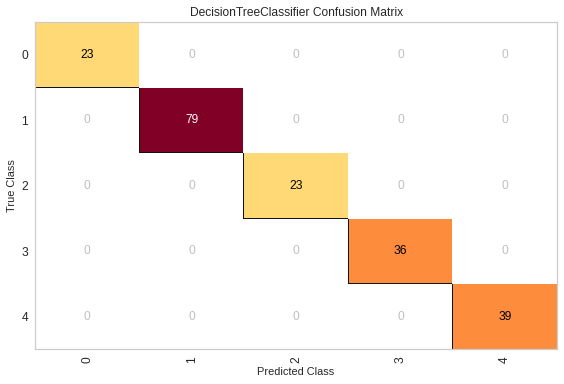

In [61]:
from yellowbrick.classifier import ConfusionMatrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(dt, classes=[0,1,2,3,4])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(features, target)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(features, target)

# How did we do?
cm.show()

***Visualizing decision rules with tree plots - Graphviz***

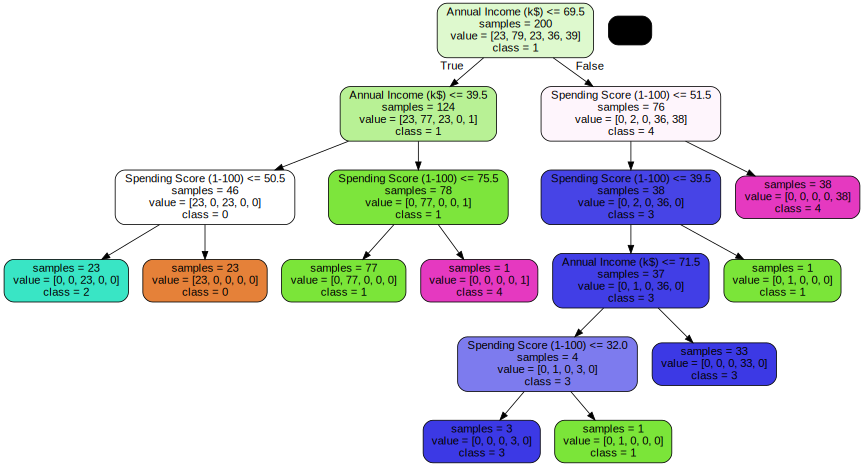

In [62]:
#Plot a decision tree using graphviz
dot_data= tree.export_graphviz(dt, out_file=None,impurity=False, 
                    feature_names=features.columns,  
                      class_names=['0', '1','2','3','4','5'],  
                      filled=True, rounded=True)

pdot = pydot.graph_from_dot_data(dot_data)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"12,12\"")
graph = Source(pdot[0].to_string())
graph

Here the difficulty is to read the decision tree. Rules need to be written out to make sense of it

We notice that some leaf nodes only contain 1 observations. It might be a good thing to restrain our tree in order to avoid having such a small node.

***Visualizing decision rules with tree plots - Dtreeviz***

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


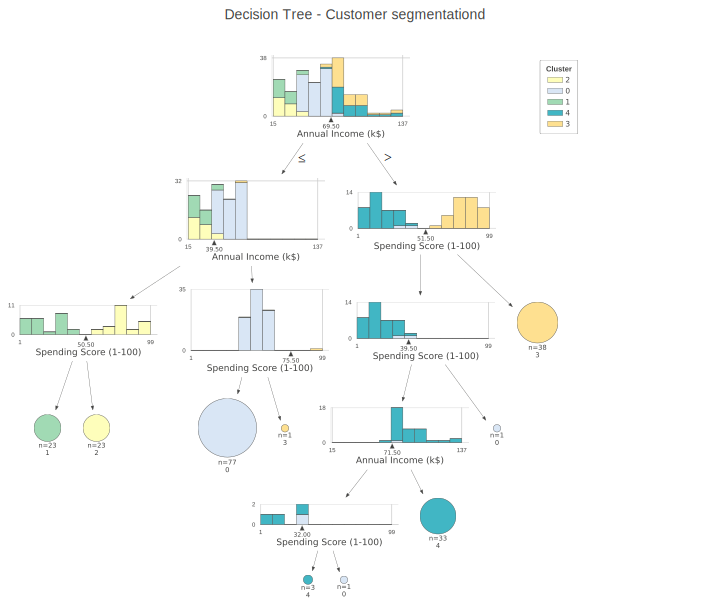

In [63]:
# Plot the dtreeviz plot
viz = dtreeviz(dt, 
               x_data=features,
               y_data=target,
               target_name="Cluster",
               feature_names=features.columns, 
               class_names=list(target.unique()),
               title="Decision Tree - Customer segmentationd")
# Show the plot
viz

Dtreeviz plot is more easily interpreted than the decision tree plot we viewed earlier. We can clearly see that whether Annual income and Speding score are high or low, observations get classified into a cluster or another.


Looking at the different tree graphs, we notice that Spending score and Annual score are the 2 variables influencing clusters.

***Feature importance***

We will now plot our feature importance plot to see how features are contributing to model performance

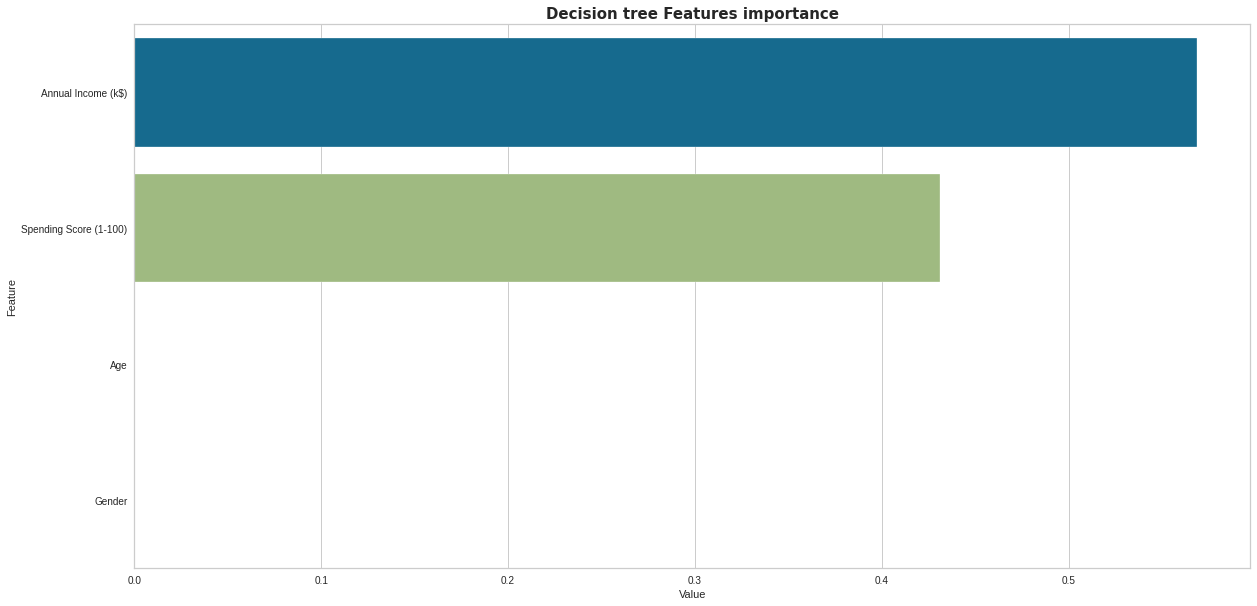

In [64]:
feature_imp = pd.DataFrame(sorted(zip(dt.feature_importances_, 
                                     data.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Decision tree Features importance',fontname="DejaVu Sans", size=15,fontweight="bold")

plt.show();

Annual Income and Spending Score both impact strongly Clusters which we already knew. However, Age and Gender have absolutely no impact on model performance.

---

# Conclusion
We have reached the end of our project. My aim, clustering our customers base while explaining clusters, has been reached.

Data visualization has been a key tool in my project :
- to determine the ideal number of clusters before modeling
- to evaluate optimal number of clusters post modelling (using Elbow and Silhouette plots)
- to determine how clusters were created using tree plots with our classification model

Clusters can be easily explained using other models by using clusters as target variables. Unfortunately, most tutorials / use cases tends to skip the cluster explainibility part.

In my project, clustering explanability was facilitated by fact that our dataset was pretty small with only 5 columns incl. CustomerID.

With bigger dataset, it might be required to perform feature selection with the classification model in order to keep only relevant attributes.

---